In [58]:
import numpy as np
import torch, torch.optim as optim
import torch.nn as nn
from matplotlib import pyplot as plt
from torch.utils.data import TensorDataset, DataLoader
import seaborn as sns

- Build a toy classification dataset
    - Samples inside circle boundary should have label 0 and samples outside circle boundary should have label 1

/home/ajrfhp/anaconda3/envs/reddevils_nlp/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


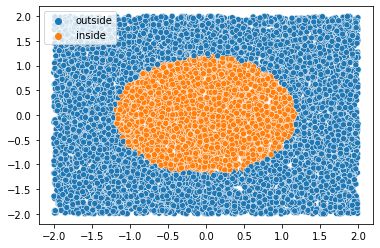

-0.005498850914990982

In [83]:
X = np.random.rand(10000, 2) * 4 - 2
Y = np.array([1 if x[0] * x[0] + x[1] * x[1] >= np.sqrt(2) else 0 for x in X])
colors = [ 'outside' if y else 'inside' for y in Y]


sns.scatterplot(X[:,0], X[:,1], hue=colors)
plt.show()
X.shape


In [85]:
def get_train_test_dataset(X, Y):
    indices = np.random.permutation(len(X)).astype(int)
    X, Y = X[indices,:], Y[indices]
    
    X = torch.from_numpy(X).reshape((-1, 2)).double()
    Y = torch.from_numpy(Y).reshape((-1, 1)).double()
    
    train_length = int(0.8 * len(X))
    X_train, Y_train = X[:train_length], Y[:train_length]
    X_test, Y_test = X[train_length:], Y[train_length:]
    

    train_loader = DataLoader(TensorDataset(X_train, Y_train), batch_size=100)
    test_loader = DataLoader(TensorDataset(X_test, Y_test), batch_size=100)

    return train_loader, test_loader

train_loader, test_loader = get_train_test_dataset(X, Y)


In [88]:
class LinearModel(nn.Module):
    def __init__(self) -> None:
        super(LinearModel, self).__init__()
        self.fc1 = nn.Linear(2, 10)
        self.fc2 = nn.Linear(10, 1)

    def forward(self, x):
        x =  nn.ReLU()(self.fc1(x))
        return nn.Sigmoid()(self.fc2(x))


model = LinearModel().double()
model.forward(torch.tensor([4, 5]).double())

for name, param in model.named_parameters():
    print(name, param)

fc1.weight Parameter containing:
tensor([[ 0.4093,  0.1144],
        [ 0.5711, -0.3488],
        [-0.6860, -0.4410],
        [ 0.6118, -0.1979],
        [ 0.6545,  0.2895],
        [-0.4768,  0.6562],
        [-0.6094,  0.7000],
        [-0.1951,  0.4928],
        [-0.1249,  0.5008],
        [-0.2780, -0.6129]], dtype=torch.float64, requires_grad=True)
fc1.bias Parameter containing:
tensor([-0.6503,  0.0866, -0.6546,  0.6276, -0.6653, -0.3684,  0.1192,  0.0244,
        -0.0138, -0.2733], dtype=torch.float64, requires_grad=True)
fc2.weight Parameter containing:
tensor([[ 0.1437, -0.2041,  0.2706,  0.1549, -0.0965,  0.1303,  0.2569,  0.2865,
          0.1539, -0.0795]], dtype=torch.float64, requires_grad=True)
fc2.bias Parameter containing:
tensor([-0.1981], dtype=torch.float64, requires_grad=True)


/tmp/ipykernel_1438/1922903019.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  prediction = torch.tensor(predictions)
/home/ajrfhp/anaconda3/envs/reddevils_nlp/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


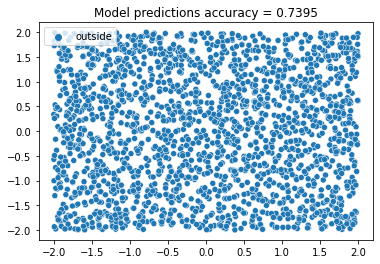

0.19829810268562048


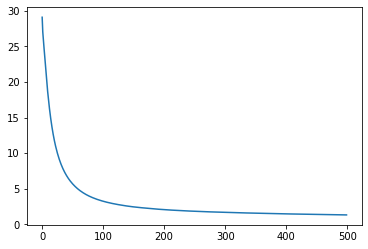

/tmp/ipykernel_1438/1922903019.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  prediction = torch.tensor(predictions)
/home/ajrfhp/anaconda3/envs/reddevils_nlp/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


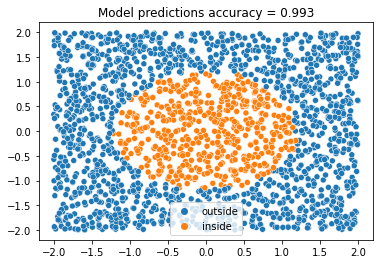

0.005811928910680131


In [89]:
def train(model, train_loader, optimizer, num_epochs=500):
    running_losses = []
    for epoch in range(num_epochs):
        running_loss = 0
        for i, (X_train, Y_train) in enumerate(train_loader):
            predictions = model.forward(X_train)
            loss = nn.functional.binary_cross_entropy(predictions, Y_train)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            if i % 50 == 0 and i > 0:
                running_losses.append(running_loss)
                running_loss = 0

    plt.plot(np.arange(len(running_losses)), running_losses)
    plt.show()

def eval(model, test_loader, visualize=False):
    sum_loss, count_loss = 0, 0
    correct, total = 0, 0
    X_tests, Y_tests, predictionss = [], [], []
    for i, (X_test, Y_test) in enumerate(test_loader):
        predictions = model.forward(X_test)
        loss = nn.MSELoss()(predictions, Y_test)
        sum_loss += loss.item()
        count_loss += 1

        prediction = torch.tensor(predictions)
        prediction[prediction.ge(0.5)] = 1
        prediction[prediction.le(0.5)] = 0
        correct += len(prediction[prediction == Y_test])
        total += len(prediction)

        X_tests.extend(np.array(X_test))
        Y_tests.extend(Y_test)
        predictionss.extend(predictions.detach().numpy())
    
    if visualize:
        colors = [ 'outside' if y >= 0.5 else 'inside' for y in predictionss]
        X_tests = np.array(X_tests)
        plt.title(f'Model predictions accuracy = {correct/total}')
        sns.scatterplot(X_tests[:,0], X_tests[:,1], hue=colors)
        plt.show()


    print(sum_loss / count_loss)

model = LinearModel().double()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
eval(model, test_loader, visualize=True)
train(model, train_loader, optimizer)
eval(model, test_loader, visualize=True)